# Yarrowia Media Matrix 

### Takes generated media matrix and clusters groups for dimensionality reduction. Arbitrarily sets bounds and cluster groups, then uses LHS to sample points within bounds for initial experimental set.

#### this file is mostly copied from 'Yarrowia linear hierarchial tree reduction.ipynb' from ML_for_rational_design repo

In [89]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram

from pyDOE3 import lhs
import torch

In [60]:
# read in g/L data for dimensional reduction 
df = pd.read_csv("data/Media-Matrix-Combined-v5-grams-per-litre.csv")

#df = pd.read_csv("data/Media-Matrix-Combined-v5-moles-per-litre.csv")  # uncomment this line to use mol/L version

# mol/L version will give same cluster results

# filter rows that are considered not important
compounds_to_remove = [
    'Dipotassium phosphate', 'Disodium edta dihydrate', 'EDTA', 'Monopotassium phosphate',
    'Phosphoric acid', 'Potassium hydroxide', 'Sodium citrate dihydrate', 'Sodium phosphate',
    'Sulphuric acid', 'Uracil'
]

df = df[~df['Compound'].isin(compounds_to_remove)].copy()

# remove pubchemid
df.drop(df.columns[1], axis=1, inplace=True)

# separate numeric columns for transformation
num_df = df.select_dtypes(include='number')
labels = df[['Compound', 'Annotate']]

yar_df = df.filter(like='_YAR')
#cer_df = df_log.filter(like='_CER')
#pic_df = df_log.filter(like='_PIC')

yar_df_labeled = pd.concat([labels, yar_df], axis=1)

# Define which columns are sample measurements (everything except metadata)
sample_cols = yar_df_labeled.columns.difference(['Compound', 'Annotate'])

# Filter to keep rows where at least one sample value ≠ 0   # this bit was changed for the linear version of this process pipeline
yar_df_labeled = yar_df_labeled[
    yar_df_labeled['Annotate'].isin(['Vitamin', 'Element']) &
    ~(yar_df_labeled[sample_cols] == 0).all(axis=1)
].copy()

# let's remove redundant elements for calcium iron, manganese, sodium chloride and zinc chloride
yar_df_labeled = yar_df_labeled.drop(index=[9, 16, 29, 35, 46, 59])

yar_df_element = yar_df_labeled[yar_df_labeled['Annotate'] == 'Element'].copy()
yar_df_vitamin = yar_df_labeled[yar_df_labeled['Annotate'] == 'Vitamin'].copy()


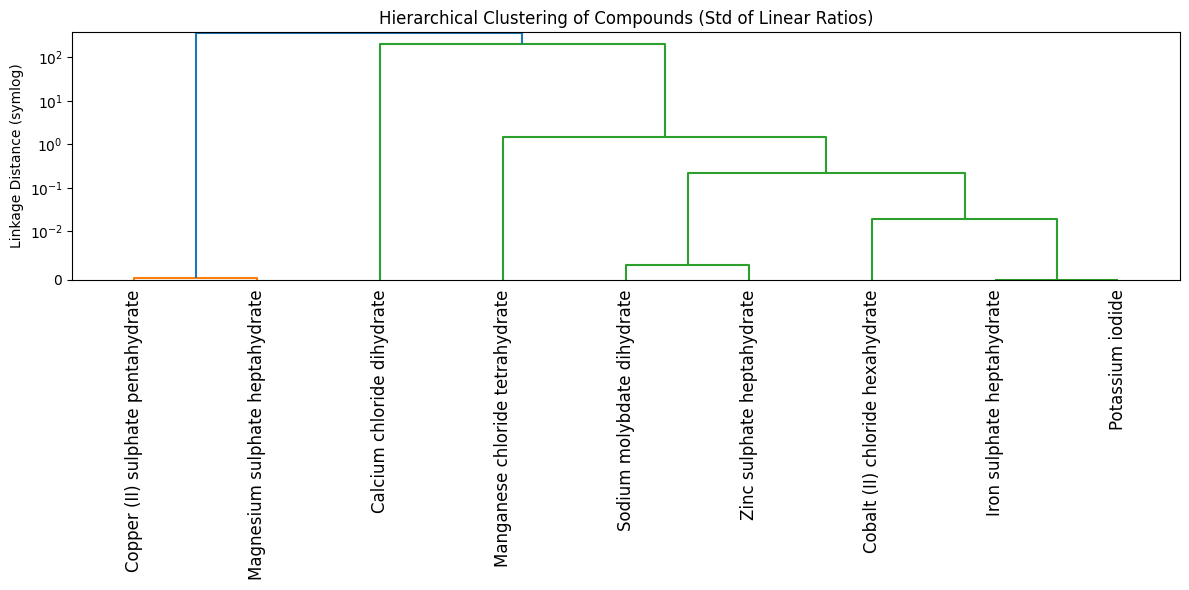

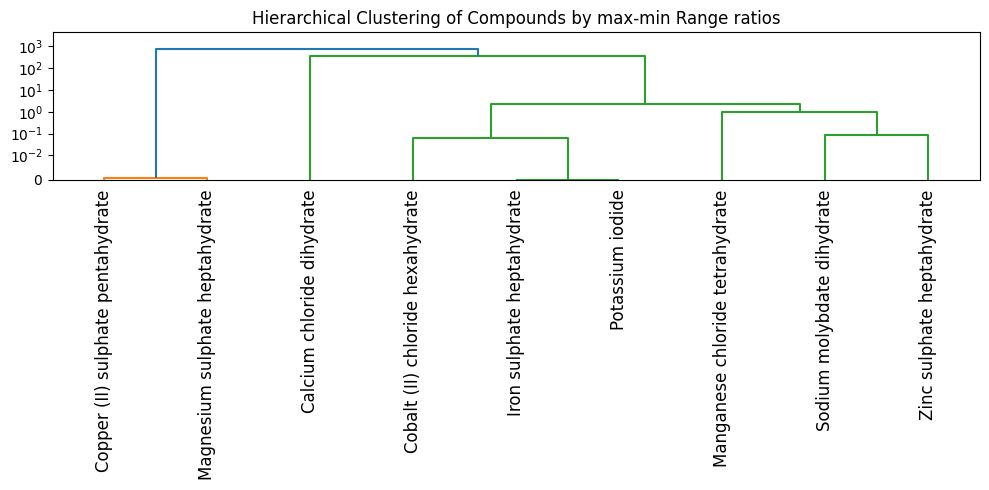

 Step  Cluster_ID                                                                 Merged_Cluster_1                                                                                                                                                                                      Merged_Cluster_2  Linkage_Distance  Num_Compounds
    1           9                                                     [Iron sulphate heptahydrate]                                                                                                                                                                                    [Potassium iodide]          0.000000              2
    2          10                                              [Copper (II) sulphate pentahydrate]                                                                                                                                                                     [Magnesium sulphate heptahydrate]          0.000520              2
    3     

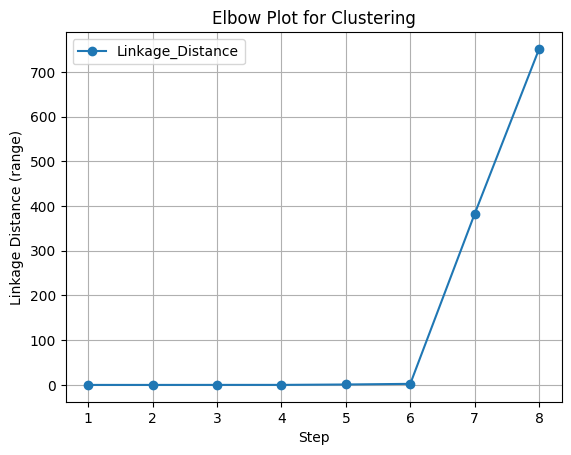

In [61]:
df_e = yar_df_element.copy()
sample_cols = df_e.columns.difference(['Compound', 'Annotate'])

ratios = []


# all unique compound pairs
compound_pairs = list(itertools.combinations(df_e['Compound'], 2))

# map for quick lookup
compound_map = df_e.set_index('Compound')[sample_cols]

# loop through pairs
for c1, c2 in compound_pairs:
    vals1 = compound_map.loc[c1]
    vals2 = compound_map.loc[c2]

    # per-column mask
    valid_mask = (vals1>0) & (vals2 >0)
    ratio = vals1/vals2 #

    #only keeps valid entries
    ratio_filtered = ratio.where(valid_mask)

    # store as a row with all per-column ratios
    row = {
        'Compound_1': c1,
        'Compound_2': c2,
        **ratio_filtered.to_dict()
    }
    ratios.append(row)

# create a dataframe
ratio_df_e = pd.DataFrame(ratios)

ratio_df_e_reduced = ratio_df_e.drop(columns = ['1_YAR', '2b_YAR', '2c_YAR', '2d_YAR', '3b_YAR', '3c_YAR', '6_YAR']) 
# to remove 2b to 2d Yar (which are the same as 2a) and 3b(which was all nans) 3c was dropped as it was focused on protein yiedl rather than hcd/growth
# I've also removed 1_YAR as it is out of whack compared to others
#6_YAR is removed, though it was added as it's the origin paper for 3c, which was found to be inconsistent

# Step 1: Compute SD per row
sample_cols = ratio_df_e_reduced.columns.difference(['Compound_1', 'Compound_2'])
ratio_df_e_reduced['Std_Ratio'] = ratio_df_e_reduced[sample_cols].replace(0, np.nan).std(axis=1, skipna=True)

# Step 2: Create list of all unique compounds
compounds = pd.unique(ratio_df_e_reduced[['Compound_1', 'Compound_2']].values.ravel())

# Step 3: Initialize empty distance matrix
distance_matrix = pd.DataFrame(np.nan, index=compounds, columns=compounds)

# Step 4: Fill matrix with std values (symmetric)
for _, row in ratio_df_e_reduced.iterrows():
    c1, c2, std = row['Compound_1'], row['Compound_2'], row['Std_Ratio']
    distance_matrix.loc[c1, c2] = std
    distance_matrix.loc[c2, c1] = std

# Step 5: Set diagonal to 0
np.fill_diagonal(distance_matrix.values, 0)

# Step 6: Check for missing values
if distance_matrix.isnull().any().any():
    raise ValueError("Distance matrix contains NaNs — some compound pairs are missing.")

# Step 7: Run hierarchical clustering
condensed_dist = squareform(distance_matrix.values)
Z = linkage(condensed_dist, method='average')

# Step 8: Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=distance_matrix.index.tolist(), leaf_rotation=90)#, color_threshold=100)
plt.yscale('symlog', linthresh=.01)
plt.ylabel("Linkage Distance (symlog)")
plt.title("Hierarchical Clustering of Compounds (Std of Linear Ratios)")
plt.tight_layout()
plt.show()


'''Below generates the max-min range ratios which makes sense as with so 
few experiments remaining after removal of invalids and redundants'''
# in this instance, the two plots should be virutally identical

# select only numeric columns excluding compound ID columns
numeric_cols = ratio_df_e_reduced.drop(columns=['Compound_1', 'Compound_2']).select_dtypes(include='number').columns

# create new dataframe with range values
range_df_e = pd.DataFrame({
    'Compound_1': ratio_df_e_reduced['Compound_1'],
    'Compound_2': ratio_df_e_reduced['Compound_2'],
    'range': ratio_df_e_reduced[numeric_cols].replace(0, np.nan).max(axis=1) - ratio_df_e_reduced[numeric_cols].replace(0, np.nan).min(axis=1)
})

# Create a square distance matrix
compounds = pd.unique(range_df_e[['Compound_1', 'Compound_2']].values.ravel())
distance_matrix = pd.DataFrame(0, index=compounds, columns=compounds, dtype=float)

# Fill in distances symmetrically
for _, row in range_df_e.iterrows():
    c1, c2, dist = row['Compound_1'], row['Compound_2'], row['range']
    distance_matrix.loc[c1, c2] = dist
    distance_matrix.loc[c2, c1] = dist

# Ensure zero diagonal
np.fill_diagonal(distance_matrix.values, 0)

if distance_matrix.isnull().any().any():
    raise ValueError("Distance matrix contains NaNs — some compound pairs are missing.")

# Convert square matrix to condensed distance matrix
condensed_dist = squareform(distance_matrix.values)

# Perform hierarchical clustering
Z = linkage(condensed_dist, method='average')

# Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(Z, labels=distance_matrix.index.tolist(), leaf_rotation=90)
plt.title("Hierarchical Clustering of Compounds by max-min Range ratios")
plt.yscale('symlog', linthresh=0.01)
plt.ylim(0, distance_matrix.values.max() * 1.2)
plt.tight_layout()
plt.show()



''' this section generates a table of merge steps for the hierarchical clustering'''
# Get compound names
compounds = list(distance_matrix.index)

# Number of original observations
n = len(compounds)

# This will store merge history
merge_history = []

# Track cluster membership (compound names or merged groups)
clusters = {i: [compounds[i]] for i in range(n)}

# Loop over linkage matrix Z
for step, (idx1, idx2, dist, sample_count) in enumerate(Z):
    idx1, idx2 = int(idx1), int(idx2)
    
    # Get the clusters being merged
    members1 = clusters[idx1]
    members2 = clusters[idx2]

    # Merge the two clusters
    new_cluster = members1 + members2
    clusters[n + step] = new_cluster

    # Save merge info
    merge_history.append({
        'Step': step + 1,
        'Cluster_ID': n + step,
        'Merged_Cluster_1': members1,
        'Merged_Cluster_2': members2,
        'Linkage_Distance': dist,
        'Num_Compounds': len(new_cluster),
    })

# Convert to dataframe for easier viewing
merge_df = pd.DataFrame(merge_history)

# Display the merge table sorted by step (or by distance, if you prefer)
merge_df_sorted = merge_df.sort_values('Linkage_Distance', ascending=True)

# Print the table or write to CSV
print(merge_df_sorted.to_string(index=False))
# merge_df_sorted.to_csv("compound_merge_steps.csv", index=False)

merge_df_sorted[['Step', 'Linkage_Distance']].plot(x='Step', y='Linkage_Distance', marker='o')
plt.ylabel("Linkage Distance (range)")
plt.title("Elbow Plot for Clustering")
plt.grid(True)
plt.show()


Vitamin hierarchical tree (same as above which was for elements)

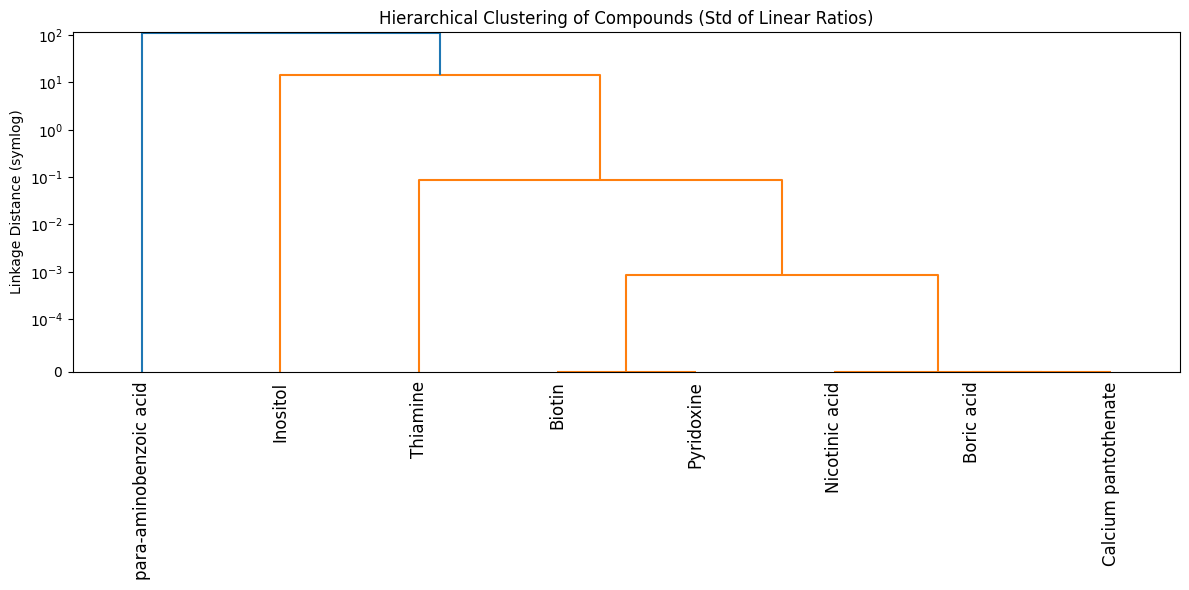

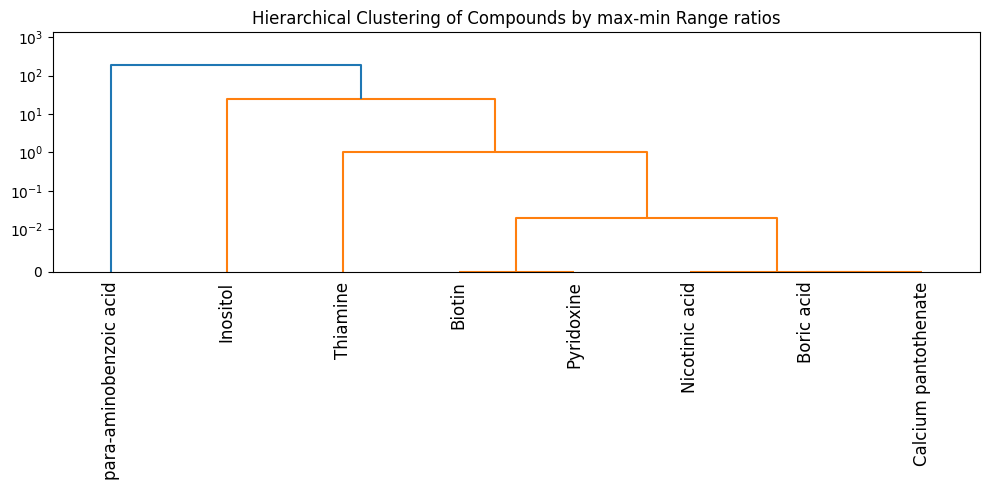

 Step  Cluster_ID         Merged_Cluster_1                                                                           Merged_Cluster_2  Linkage_Distance  Num_Compounds
    1           8                 [Biotin]                                                                               [Pyridoxine]          0.000000              2
    2           9             [Boric acid]                                                                     [Calcium pantothenate]          0.000000              2
    3          10         [Nicotinic acid]                                                         [Boric acid, Calcium pantothenate]          0.000000              3
    4          11     [Biotin, Pyridoxine]                                         [Nicotinic acid, Boric acid, Calcium pantothenate]          0.019967              5
    5          12               [Thiamine]                     [Biotin, Pyridoxine, Nicotinic acid, Boric acid, Calcium pantothenate]          1.003517              

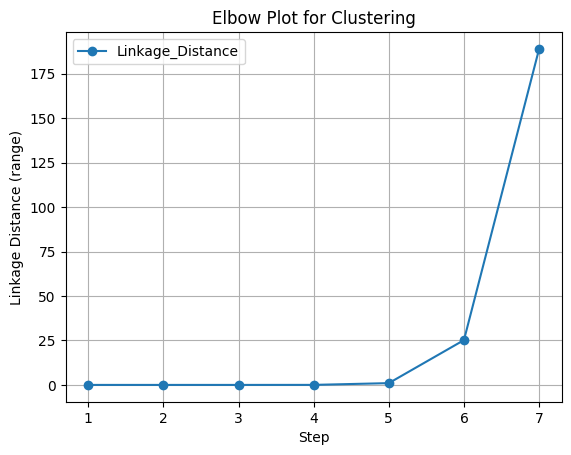

In [62]:
df_v = yar_df_vitamin.copy()
sample_cols = df_v.columns.difference(['Compound', 'Annotate'])

ratios = []


# all unique compound pairs
compound_pairs = list(itertools.combinations(df_v['Compound'], 2))

# map for quick lookup
compound_map = df_v.set_index('Compound')[sample_cols]

# loop through pairs
for c1, c2 in compound_pairs:
    vals1 = compound_map.loc[c1]
    vals2 = compound_map.loc[c2]

    # per-column mask
    valid_mask = (vals1>0) & (vals2 >0)
    ratio = vals1/vals2 

    #only keeps valid entries
    ratio_filtered = ratio.where(valid_mask)

    # store as a row with all per-column ratios
    row = {
        'Compound_1': c1,
        'Compound_2': c2,
        **ratio_filtered.to_dict()
    }
    ratios.append(row)

# create a dataframe
ratio_df_v = pd.DataFrame(ratios)

# drop these as they are simply repeats (this study varies carbon and nitrogen source which will be constant for our purposes)
# 1_YAR also removed
# note that 3b is kept for vitamins (but not for elements) as not everything was nans.
#6_YAR removed as it is a protein expression study like 3c
ratio_df_v_reduced = ratio_df_v.drop(columns=['1_YAR','2b_YAR', '2c_YAR', '2d_YAR', '3c_YAR', '6_YAR'])

# Step 1: Compute SD per row
sample_cols = ratio_df_v_reduced.columns.difference(['Compound_1', 'Compound_2'])
ratio_df_v_reduced['Std_Ratio'] = ratio_df_v_reduced[sample_cols].replace(0, np.nan).std(axis=1, skipna=True) # added replace 0 for correct std calc

# Step 2: Create list of all unique compounds
compounds = pd.unique(ratio_df_v_reduced[['Compound_1', 'Compound_2']].values.ravel())

# Step 3: Initialize empty distance matrix
distance_matrix = pd.DataFrame(np.nan, index=compounds, columns=compounds)

# Step 4: Fill matrix with std values (symmetric)
for _, row in ratio_df_v_reduced.iterrows():
    c1, c2, std = row['Compound_1'], row['Compound_2'], row['Std_Ratio']
    distance_matrix.loc[c1, c2] = std
    distance_matrix.loc[c2, c1] = std

# Step 5: Set diagonal to 0
np.fill_diagonal(distance_matrix.values, 0)

# Step 6: Check for missing values
if distance_matrix.isnull().any().any():
    raise ValueError("Distance matrix contains NaNs — some compound pairs are missing.")

# Step 7: Run hierarchical clustering
condensed_dist = squareform(distance_matrix.values)
Z = linkage(condensed_dist, method='average')

# Step 8: Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=distance_matrix.index.tolist(), leaf_rotation=90)
plt.yscale('symlog', linthresh=.0001)
plt.ylabel("Linkage Distance (symlog)")
plt.title("Hierarchical Clustering of Compounds (Std of Linear Ratios)")
plt.tight_layout()
plt.show()



'''min-max range ratios for vitamins below'''

# select only numeric columns excluding compound ID columns
numeric_cols = ratio_df_v_reduced.drop(columns=['Compound_1', 'Compound_2']).select_dtypes(include='number').columns

# create new dataframe with range values
range_df_v = pd.DataFrame({
    'Compound_1': ratio_df_v_reduced['Compound_1'],
    'Compound_2': ratio_df_v_reduced['Compound_2'],
    'range': ratio_df_v_reduced[numeric_cols].replace(0, np.nan).max(axis=1) - ratio_df_v_reduced[numeric_cols].replace(0, np.nan).min(axis=1)
})

# Create a square distance matrix
compounds = pd.unique(range_df_v[['Compound_1', 'Compound_2']].values.ravel())
distance_matrix = pd.DataFrame(0, index=compounds, columns=compounds, dtype=float)

# Fill in distances symmetrically
for _, row in range_df_v.iterrows():
    c1, c2, dist = row['Compound_1'], row['Compound_2'], row['range']
    distance_matrix.loc[c1, c2] = dist
    distance_matrix.loc[c2, c1] = dist

# Ensure zero diagonal
np.fill_diagonal(distance_matrix.values, 0)

if distance_matrix.isnull().any().any():
    raise ValueError("Distance matrix contains NaNs — some compound pairs are missing.")

# Convert square matrix to condensed distance matrix
condensed_dist = squareform(distance_matrix.values)

# Perform hierarchical clustering
Z = linkage(condensed_dist, method='average')

# Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(Z, labels=distance_matrix.index.tolist(), leaf_rotation=90)
plt.title("Hierarchical Clustering of Compounds by max-min Range ratios")
plt.yscale('symlog', linthresh=0.01)
plt.ylim(0, distance_matrix.values.max() * 1.2)
plt.tight_layout()
plt.show()

'''this bit generates the merge table for the hierarchical clustering'''
# Get compound names
compounds = list(distance_matrix.index)

# Number of original observations
n = len(compounds)

# This will store merge history
merge_history = []

# Track cluster membership (compound names or merged groups)
clusters = {i: [compounds[i]] for i in range(n)}

# Loop over linkage matrix Z
for step, (idx1, idx2, dist, sample_count) in enumerate(Z):
    idx1, idx2 = int(idx1), int(idx2)
    
    # Get the clusters being merged
    members1 = clusters[idx1]
    members2 = clusters[idx2]

    # Merge the two clusters
    new_cluster = members1 + members2
    clusters[n + step] = new_cluster

    # Save merge info
    merge_history.append({
        'Step': step + 1,
        'Cluster_ID': n + step,
        'Merged_Cluster_1': members1,
        'Merged_Cluster_2': members2,
        'Linkage_Distance': dist,
        'Num_Compounds': len(new_cluster),
    })

# Convert to dataframe for easier viewing
merge_df = pd.DataFrame(merge_history)

# Display the merge table sorted by step (or by distance, if you prefer)
merge_df_sorted = merge_df.sort_values('Linkage_Distance', ascending=True)

# Print the table or write to CSV
print(merge_df_sorted.to_string(index=False))
# merge_df_sorted.to_csv("compound_merge_steps.csv", index=False)

merge_df_sorted[['Step', 'Linkage_Distance']].plot(x='Step', y='Linkage_Distance', marker='o')
plt.ylabel("Linkage Distance (range)")
plt.title("Elbow Plot for Clustering")
plt.grid(True)
plt.show()


# Alpha generator 1.1 and tool for clustering reduction, converting between raw and transfored data, and generating BO boundaries

## Alpha generator has been updated to choose expanded min max bounds

In [73]:
class ClusterScaler:
    def __init__(self, df, cluster_compounds):
        """
        Args:
            df (pd.DataFrame): Must contain 'Compound', 'Min', 'Max', and 'Median' columns
            cluster_compounds (list of str): List of compounds to include in this cluster
        """
        self.df = df.set_index("Compound")
        self.compounds = cluster_compounds

        # Pull stats
        self.medians = self.df.loc[self.compounds, "Median"].to_dict()

        # use expaned bounds if available, otherwise use original min/max
        if 'Expanded_Min' in self.df.columns and 'Expanded_Max' in self.df.columns:
            self.mins = self.df.loc[self.compounds, "Expanded_Min"].to_dict()
            self.maxs = self.df.loc[self.compounds, "Expanded_Max"].to_dict()
        else:
            self.mins = self.df.loc[self.compounds, "Min"].to_dict()
            self.maxs = self.df.loc[self.compounds, "Max"].to_dict()

        # Log10 of medians
        self.log10_medians = {k: np.log10(v) for k, v in self.medians.items()}
        self.mean_log10 = np.mean(list(self.log10_medians.values()))

        # Offsets c_i
        self.offsets = {k: v - self.mean_log10 for k, v in self.log10_medians.items()}

    def log_concentration_from_alpha(self, alpha):
        return {compound: alpha + offset for compound, offset in self.offsets.items()}

    def concentration_from_alpha(self, alpha):
        return {compound: 10**(alpha + offset) for compound, offset in self.offsets.items()}

    def solve_alpha_for_target(self, compound, target_concentration):
        if compound not in self.offsets:
            raise ValueError(f"Compound '{compound}' not in this cluster.")
        return np.log10(target_concentration) - self.offsets[compound]

    def get_alpha_bounds(self):
        alpha_mins = []
        alpha_maxs = []

        for compound in self.compounds:
            c_i = self.offsets[compound]
            min_val = self.mins[compound]
            max_val = self.maxs[compound]
            alpha_min_i = np.log10(min_val) - c_i
            alpha_max_i = np.log10(max_val) - c_i
            alpha_mins.append(alpha_min_i)
            alpha_maxs.append(alpha_max_i)

        alpha_min = min(alpha_mins)
        alpha_max = max(alpha_maxs)

        if alpha_min > alpha_max:
            raise ValueError("No valid alpha range — bounds conflict between compounds.")

        return alpha_min, alpha_max

In [64]:
df_e_reduced = df_e.drop(columns = ['1_YAR', '2b_YAR', '2c_YAR', '2d_YAR', '3b_YAR', '3c_YAR', '6_YAR']) 

df_e_reduced_nan = df_e_reduced.replace(0, np.nan) # replace 0 with Nans so correct min can be extracted
#selects numeric columns only
numeric_cols_e = df_e_reduced_nan.select_dtypes(include=[np.number]).columns


# Compute min and max for each compound, excluding NaNs
min_values = df_e_reduced_nan[numeric_cols_e].min(axis=1, skipna=True)
max_values = df_e_reduced_nan[numeric_cols_e].max(axis=1, skipna=True)
median_values = df_e_reduced_nan[numeric_cols_e].median(axis=1, skipna = True)
mean_values = df_e_reduced_nan[numeric_cols_e].mean(axis=1, skipna = True)

# Create a new dataframe with Compound, Min, and Max
df_e_min_max = pd.DataFrame({
    'Compound': df_e_reduced_nan['Compound'],
    'Min': min_values,
    'Max': max_values,
    'Median': median_values,
    'Mean': mean_values
})

# ========== Vitamin section below ==========

df_v_reduced = df_v.drop(columns=['1_YAR','2b_YAR', '2c_YAR', '2d_YAR', '3c_YAR', '6_YAR'])

df_v_reduced_nan = df_v_reduced.replace(0, np.nan) # replace 0 with Nans so correct min can be extracted

#selects numeric columns only
numeric_cols_v = df_v_reduced_nan.select_dtypes(include=[np.number]).columns

# Compute min and max for each compound, excluding NaNs
min_values = df_v_reduced_nan[numeric_cols_v].min(axis=1, skipna=True)
max_values = df_v_reduced_nan[numeric_cols_v].max(axis=1, skipna=True)
median_values = df_v_reduced_nan[numeric_cols_v].median(axis=1, skipna = True)
mean_values = df_v_reduced_nan[numeric_cols_v].mean(axis=1, skipna = True)

# Create a new dataframe with Compound, Min, and Max
df_v_min_max = pd.DataFrame({
    'Compound': df_v_reduced_nan['Compound'],
    'Min': min_values,
    'Max': max_values,
    'Median': median_values,
    'Mean': mean_values
})

In [68]:
def expand_bounds(min_val, max_val, percent=0.1):
    expanded_min = min_val / (1 + percent)
    expanded_max = max_val * (1 + percent)
    return expanded_min, expanded_max

# Apply the expansion row-wise

df_e_min_max[['Expanded_Min', 'Expanded_Max']] = df_e_min_max.apply(
    lambda row: pd.Series(expand_bounds(row['Min'], row['Max'])),
    axis=1
)

df_v_min_max[['Expanded_Min', 'Expanded_Max']] = df_v_min_max.apply(
    lambda row: pd.Series(expand_bounds(row['Min'], row['Max'])),
    axis=1
)

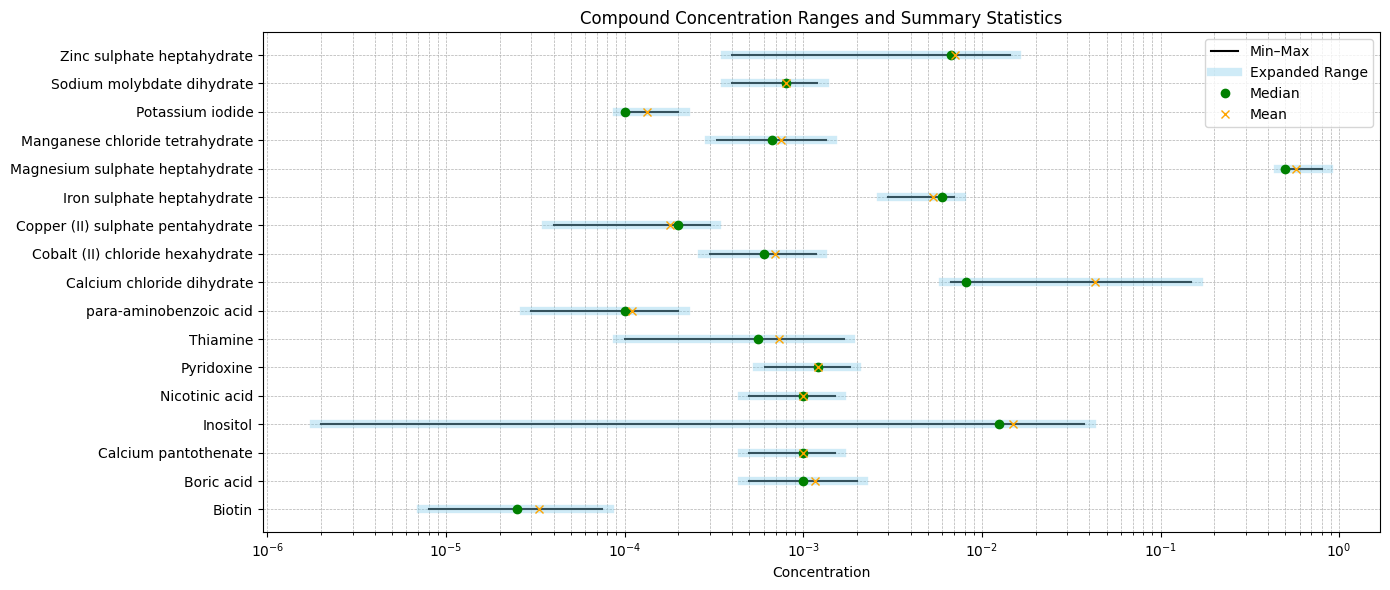

In [72]:
df_all = pd.concat([df_v_min_max, df_e_min_max], ignore_index=True)
# Sort compounds by median or mean for clean axis ordering
df_sorted = df_all#.sort_values(by='Median')

plt.figure(figsize=(14, 6))

for i, row in enumerate(df_sorted.itertuples()):
    y = i
    
    # Plot original Min–Max as a narrow line
    plt.plot([row.Min, row.Max], [y, y], color='black', lw=1.5, label='Min–Max' if i == 0 else "")

    # Plot expanded range as a thick semi-transparent bar
    plt.plot([row.Expanded_Min, row.Expanded_Max], [y, y], color='skyblue', lw=6, alpha=0.4, label='Expanded Range' if i == 0 else "")
    
    # Mark median and mean
    plt.plot(row.Median, y, 'o', color='green', label='Median' if i == 0 else "")
    plt.plot(row.Mean, y, 'x', color='orange', label='Mean' if i == 0 else "")

plt.yticks(range(len(df_sorted)), df_sorted['Compound'])
plt.xlabel("Concentration")
plt.title("Compound Concentration Ranges and Summary Statistics")
plt.legend(loc='upper right')
plt.xscale('log')  # for comparability across orders of magnitude
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [78]:
# cluster order here is arbitrary, but we want separate scalers for conversion when transforming data

cluster_e1 = ['Copper (II) sulphate pentahydrate', 'Manganese chloride tetrahydrate']
scaler_e1 = ClusterScaler(df_e_min_max, cluster_e1)

cluster_e2 = ['Cobalt (II) chloride hexahydrate', 'Iron sulphate heptahydrate', 'Potassium iodide']
scaler_e2 = ClusterScaler(df_e_min_max, cluster_e2)

cluster_e3 = ['Magnesium sulphate heptahydrate', 'Sodium molybdate dihydrate', 'Zinc sulphate heptahydrate']
scaler_e3 = ClusterScaler(df_e_min_max, cluster_e3)

cluster_v1 = ['Nicotinic acid', 'Boric acid', 'Calcium pantothenate']
scaler_v1 = ClusterScaler(df_v_min_max, cluster_v1)

cluster_v2 = ['Biotin', 'Pyridoxine']
scaler_v2 = ClusterScaler(df_v_min_max, cluster_v2)



In [ ]:
# Step 1: Name your clusters
named_clusters = {
    "cluster_e1": cluster_e1,
    "cluster_e2": cluster_e2,
    "cluster_e3": cluster_e3,
    "cluster_v1": cluster_v1,
    "cluster_v2": cluster_v2,
}

scaler_map = {
    "cluster_e1": scaler_e1,
    "cluster_e2": scaler_e2,
    "cluster_e3": scaler_e3,
    "cluster_v1": scaler_v1,
    "cluster_v2": scaler_v2,
}

# Step 2: Collect all clustered compounds
clustered_compounds = sum(named_clusters.values(), [])  # flatten list of lists

# Step 3: Get bounds for non-clustered compounds
non_cluster_e = df_e_min_max[~df_e_min_max['Compound'].isin(clustered_compounds)]
non_cluster_v = df_v_min_max[~df_v_min_max['Compound'].isin(clustered_compounds)]

non_cluster_bounds = dict(
    zip(
        non_cluster_e['Compound'].tolist() + non_cluster_v['Compound'].tolist(),
        list(non_cluster_e[['Expanded_Min', 'Expanded_Max']].itertuples(index=False, name=None)) +
        list(non_cluster_v[['Expanded_Min', 'Expanded_Max']].itertuples(index=False, name=None))
    )
)

# Step 4: Get alpha bounds for each cluster
cluster_bounds = {
    cluster_name: scaler_map[cluster_name].get_alpha_bounds()
    for cluster_name in named_clusters
}

# Step 5: log-transform non-cluster compounds (so BO bounds can be generated from them (we can easily tranform back))
non_cluster_bounds_log = {
    compound: (np.log10(lo), np.log10(hi))
    for compound, (lo, hi) in non_cluster_bounds.items()
}

# Step 6: Combine
bo_bounds = {
    **cluster_bounds,           # alpha values, already log-based
    **non_cluster_bounds_log    # log-transformed non-clustered compounds
}


In [93]:
print(bo_bounds)

{'cluster_e1': (np.float64(-4.176580462773753), np.float64(-3.093795092457303)), 'cluster_e2': (np.float64(-3.4903218472331106), np.float64(-2.8054764855886978)), 'cluster_e3': (np.float64(-3.1248485452749586), np.float64(-1.4865153129248054)), 'cluster_v1': (np.float64(-3.342422680822206), np.float64(-2.657577319177794)), 'cluster_v2': (np.float64(-4.29489343443506), np.float64(-3.2401367877188534)), 'Calcium chloride dihydrate': (np.float64(-2.2149441611269687), np.float64(-0.7853712841798824)), 'Inositol': (np.float64(-5.740362689494244), np.float64(-1.384576047114056)), 'Thiamine': (np.float64(-4.041392685158225), np.float64(-2.7327919097596554)), 'para-aminobenzoic acid': (np.float64(-4.564271430438563), np.float64(-3.657577319177794))}


## We have generated the boundaries for bayesian optimisation

Now we want to use these boundaries to generate a set of initial experiments.

In [97]:
# Step 1: Extract lower and upper bounds from bo_bounds
keys = list(bo_bounds.keys())  # Ordered list of compound or cluster names
dim_names = keys  # This matches the LHS columns
bounds_array = [bo_bounds[k] for k in keys]  # List of (min, max) tuples

# Step 2: Convert to torch.tensor
bounds = torch.tensor(bounds_array, dtype=torch.double)  # Shape: [d, 2]

# Step 3: Transpose to match expected shape [2, d]
bounds = bounds.T  # Now bounds[0] is lower, bounds[1] is upper

# Step 4: Get dimensionality
dim = bounds.shape[1]

# Step 5: Generate LHS samples
lhs_design = torch.tensor(
    lhs(n=dim, samples=78, criterion='maximin', random_state=42),
    dtype=torch.double
)

# Step 6: Scale LHS into the specified bounds
scaled_lhs_design = bounds[0] + (bounds[1] - bounds[0]) * lhs_design

In [98]:
def decode_bo_sample(sample, keys, scalers, df_min_max):
    """
    Args:
        sample (np.ndarray or torch): shape (d,)
        keys (list): names of each variable (cluster name or compound)
        scalers (dict): mapping from cluster_name → ClusterScaler
        df_min_max (DataFrame): has Expanded_Min for all compounds

    Returns:
        dict: compound → concentration (linear)
    """
    if isinstance(sample, torch.Tensor):
        sample = sample.detach().cpu().numpy()

    output = {}

    for value, key in zip(sample, keys):
        if key.startswith("cluster"):
            # Cluster: use alpha → get all compound concentrations
            cluster_scaler = scalers[key]
            conc_dict = cluster_scaler.concentration_from_alpha(value)
            output.update(conc_dict)
        else:
            # Individual compound: interpret value as log10(conc)
            conc = 10**value
            output[key] = conc

    return output

In [99]:
# Let's say lhs_design is (n_samples × d)
for i in range(lhs_design.shape[0]):
    raw_point = scaled_lhs_design[i, :]
    decoded = decode_bo_sample(
        raw_point,
        keys=list(bo_bounds.keys()),
        scalers=scaler_map,  # same dict from earlier: "cluster_v1" → scaler
        df_min_max=pd.concat([df_e_min_max, df_v_min_max])
    )
    print(f"Sample {i}:")
    for k, v in decoded.items():
        print(f"  {k}: {v:.5f} g/L")

Sample 0:
  Copper (II) sulphate pentahydrate: 0.00010 g/L
  Manganese chloride tetrahydrate: 0.00035 g/L
  Cobalt (II) chloride hexahydrate: 0.00038 g/L
  Iron sulphate heptahydrate: 0.00382 g/L
  Potassium iodide: 0.00006 g/L
  Magnesium sulphate heptahydrate: 0.22930 g/L
  Sodium molybdate dihydrate: 0.00037 g/L
  Zinc sulphate heptahydrate: 0.00310 g/L
  Nicotinic acid: 0.00048 g/L
  Boric acid: 0.00048 g/L
  Calcium pantothenate: 0.00048 g/L
  Biotin: 0.00001 g/L
  Pyridoxine: 0.00037 g/L
  Calcium chloride dihydrate: 0.10406 g/L
  Inositol: 0.00015 g/L
  Thiamine: 0.00024 g/L
  para-aminobenzoic acid: 0.00012 g/L
Sample 1:
  Copper (II) sulphate pentahydrate: 0.00005 g/L
  Manganese chloride tetrahydrate: 0.00018 g/L
  Cobalt (II) chloride hexahydrate: 0.00034 g/L
  Iron sulphate heptahydrate: 0.00338 g/L
  Potassium iodide: 0.00006 g/L
  Magnesium sulphate heptahydrate: 0.23992 g/L
  Sodium molybdate dihydrate: 0.00038 g/L
  Zinc sulphate heptahydrate: 0.00324 g/L
  Nicotinic ac

In [100]:
def plot_sampled_vs_expanded(decoded_samples, df_min_max, title="Sampled Concentrations vs Expanded Ranges"):
    import matplotlib.pyplot as plt

    # Group all decoded concentrations into lists per compound
    from collections import defaultdict
    concentration_dict = defaultdict(list)
    for sample in decoded_samples:
        for compound, conc in sample.items():
            concentration_dict[compound].append(conc)

    # Merge into single DataFrame with all summary stats
    df = df_min_max.copy()
    df["Sampled_Min"] = df["Compound"].map(lambda c: np.min(concentration_dict[c]) if c in concentration_dict else np.nan)
    df["Sampled_Max"] = df["Compound"].map(lambda c: np.max(concentration_dict[c]) if c in concentration_dict else np.nan)
    df["Sampled_Median"] = df["Compound"].map(lambda c: np.median(concentration_dict[c]) if c in concentration_dict else np.nan)

    # Sort for cleaner plotting
    df_sorted = df.sort_values(by="Median")

    # Plotting
    plt.figure(figsize=(14, 6))
    for i, row in enumerate(df_sorted.itertuples()):
        y = i

        # Original Min–Max
        plt.plot([row.Min, row.Max], [y, y], color='black', lw=1.5, label='Min–Max' if i == 0 else "")
        
        # Expanded Range
        plt.plot([row.Expanded_Min, row.Expanded_Max], [y, y], color='skyblue', lw=6, alpha=0.4, label='Expanded Range' if i == 0 else "")
        
        # Sampled Range
        plt.plot([row.Sampled_Min, row.Sampled_Max], [y, y], color='red', lw=3, alpha=0.5, label='Sampled Range' if i == 0 else "")
        
        # Mean and Median markers
        plt.plot(row.Median, y, 'o', color='green', label='Median' if i == 0 else "")
        plt.plot(row.Mean, y, 'x', color='orange', label='Mean' if i == 0 else "")

    plt.yticks(range(len(df_sorted)), df_sorted['Compound'])
    plt.xlabel("Concentration (g/L)")
    plt.title(title)
    plt.legend(loc='upper right')
    plt.xscale('log')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


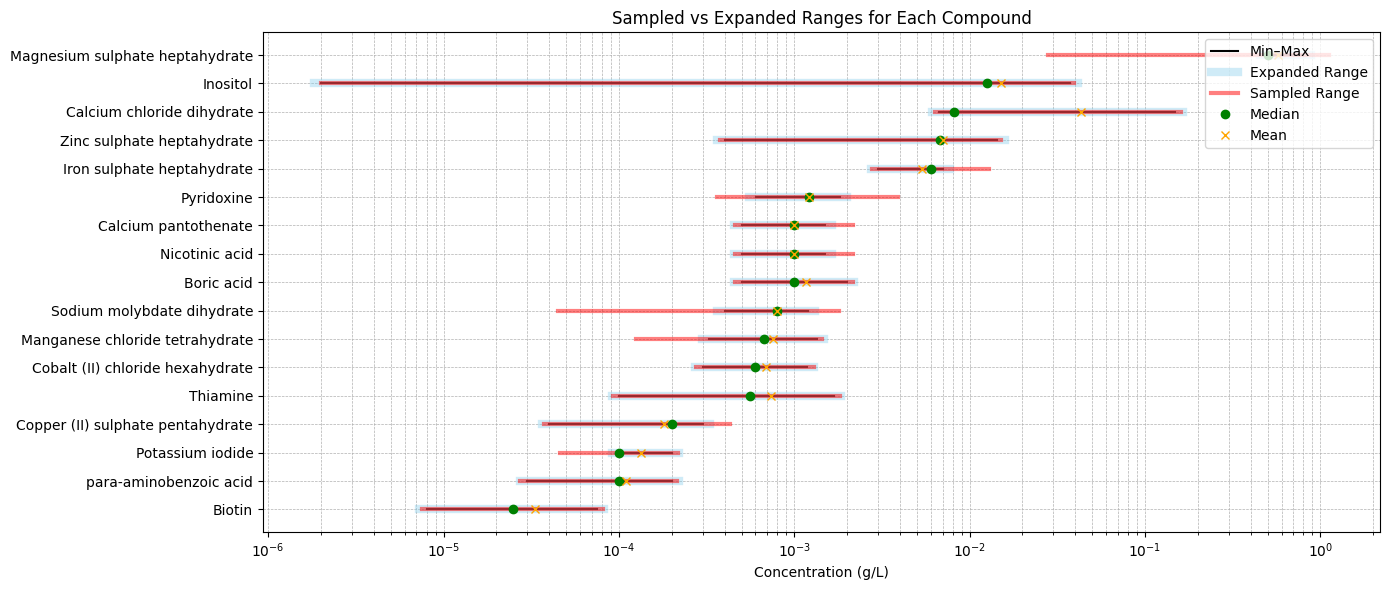

In [101]:
# Decode all LHS or BO points
decoded_samples = [
    decode_bo_sample(sample, keys, scaler_map, pd.concat([df_v_min_max, df_e_min_max]))
    for sample in scaled_lhs_design
]

# Plot
plot_sampled_vs_expanded(
    decoded_samples,
    df_min_max=pd.concat([df_v_min_max, df_e_min_max]),
    title="Sampled vs Expanded Ranges for Each Compound"
)

In [102]:
def build_sample_matrix(decoded_samples, compound_order=None):
    """
    Builds a DataFrame of decoded samples (g/L) with samples as rows, compounds as columns.

    Args:
        decoded_samples (list of dict): Output from decode_bo_sample for each point.
        compound_order (list, optional): To enforce a specific column order.

    Returns:
        pd.DataFrame: Rows = samples, Columns = compound names
    """
    df = pd.DataFrame(decoded_samples)
    if compound_order:
        df = df[compound_order]  # reorder columns
    return df

In [103]:
# Decode samples if not done yet
decoded_samples = [
    decode_bo_sample(sample, keys, scaler_map, pd.concat([df_v_min_max, df_e_min_max]))
    for sample in scaled_lhs_design
]

# Create sample matrix
compound_order = sorted(decoded_samples[0].keys())  # or use custom order
sample_matrix_df = build_sample_matrix(decoded_samples, compound_order)

# Optional: Add comment row for units (will be skipped by pandas when loading)
units_row = pd.DataFrame([["g/L"] * sample_matrix_df.shape[1]], columns=sample_matrix_df.columns)
final_df = pd.concat([units_row, sample_matrix_df], ignore_index=True)

# Export
final_df.to_csv("bo_samples_compound_matrix.csv", index=False)


In [95]:
decoded = decode_bo_sample(
    sample=scaled_lhs_design[i],
    keys=keys,
    scalers=scaler_map,
    df_min_max=pd.concat([df_v_min_max, df_e_min_max])
)

print(decoded)

{'Copper (II) sulphate pentahydrate': np.float64(7.860283051761257e-05), 'Manganese chloride tetrahydrate': np.float64(0.00026359832577526335), 'Cobalt (II) chloride hexahydrate': np.float64(0.0008409894421576418), 'Iron sulphate heptahydrate': np.float64(0.008409894421576426), 'Potassium iodide': np.float64(0.0001401649070262737), 'Magnesium sulphate heptahydrate': np.float64(0.03725185704089485), 'Sodium molybdate dihydrate': np.float64(5.960297126543182e-05), 'Zinc sulphate heptahydrate': np.float64(0.0005029000700520802), 'Nicotinic acid': np.float64(0.0008463786162129302), 'Boric acid': np.float64(0.0008463786162129302), 'Calcium pantothenate': np.float64(0.0008463786162129302), 'Biotin': np.float64(1.1596587113672509e-05), 'Pyridoxine': np.float64(0.000563830704101603), 'Calcium chloride dihydrate': np.float64(1.266210053647383), 'Inositol': np.float64(1.075479985882857), 'Thiamine': np.float64(1.0029189638499396), 'para-aminobenzoic acid': np.float64(1.0001797907040804)}


In [87]:
print(scaler_e1.concentration_from_alpha(-3.093795092457))

{'Copper (II) sulphate pentahydrate': np.float64(0.0004400000000003073), 'Manganese chloride tetrahydrate': np.float64(0.0014755609000010306)}


In [86]:
print(df_e_min_max)
print(df_v_min_max)

                             Compound       Min       Max    Median      Mean  \
7          Calcium chloride dihydrate  0.006706  0.149017  0.008125  0.042993   
11   Cobalt (II) chloride hexahydrate  0.000300  0.001175  0.000600  0.000692   
12  Copper (II) sulphate pentahydrate  0.000040  0.000300  0.000200  0.000180   
24         Iron sulphate heptahydrate  0.003000  0.007000  0.006000  0.005333   
28    Magnesium sulphate heptahydrate  0.500000  0.800000  0.500000  0.575000   
30    Manganese chloride tetrahydrate  0.000327  0.001341  0.000671  0.000753   
41                   Potassium iodide  0.000100  0.000200  0.000100  0.000133   
49         Sodium molybdate dihydrate  0.000400  0.001200  0.000800  0.000800   
60         Zinc sulphate heptahydrate  0.000400  0.014375  0.006750  0.007069   

    Expanded_Min  Expanded_Max  
7       0.006096      0.163919  
11      0.000273      0.001293  
12      0.000036      0.000330  
24      0.002727      0.007700  
28      0.454545      0.